In [1]:
using Distributions, Gadfly, DataFrames, CSV, GLM, Extremes, Random, Bootstrap, Cairo, Fontconfig, Suppressor

In [2]:
import Pkg
Pkg.add(url = "https://github.com/JuliaExtremes/IDFCurves.jl", rev="163-conversion-of-the-hessian-into-a-pdmat-object-may-cause-an-error")

    Updating git-repo `https://github.com/JuliaExtremes/IDFCurves.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/projet de recherche/julia code - réorganisation/IDFCurves package/IDFCurves.jl/docs/Project.toml`
  No Changes to `~/Desktop/projet de recherche/julia code - réorganisation/IDFCurves package/IDFCurves.jl/docs/Manifest.toml`
Precompiling project...
  ✓ IDFCurves
  1 dependency successfully precompiled in 4 seconds. 190 already precompiled.


In [3]:
using IDFCurves
import IDFCurves: getdistribution

In [4]:
include("functions_simulstudy.jl");

# Preset parameters

In [5]:
durations = [1/12, 1/6, 1/4, 1/2, 1, 2, 6, 12, 24];

d_ref = 24; # the reference duration for parameterization will always be 24h

d_out = 1/12; # the duration for validation will always be 5min

# Type I error

To study the type I error, data are simulated according to the null hypothesis (simple scaling or general scaling) and the test is performed at a $5$% rejection rate. The empirical rejection rate is measured as a function of $\xi$ and $n$ (the number of years of observation).

In [6]:
# directory where to store simulation results
objs_directory = joinpath("simulation_results", "type_I_error");
# directory where to store the figures
figs_directory = joinpath("figures", "type_I_error");

In [7]:
# range of values for the simulation parameters

# range_nyear = [20,30]; # small for testing
# range_ξ = [-0.2,0.1,0.4]; # small for testing
# Nsimul = 10; # small for testing
# 
# range_nyear = [5,20,60,100,300];
# range_ξ = -0.2:0.2:0.4;
# Nsimul = 50;

range_nyear = [5,10,20,30,40,60,80,100,200,300];
range_ξ = -0.2:0.1:0.4;
Nsimul = 500;

## Simple Scaling

### Generating test results

In [8]:
# preset parameters (used in every simulation)
μ = 2
σ = 0.3
α = 0.7;

In [9]:
# The following function returns a dataframe containing simulated pvalues of the test applied on simple scaling,
# when data are simulated according to simple scaling.
#
# The 4 columns of the returned dataframe are : ξ , nyear , key , pval.
# "ξ" and "nyear" contain the shape parameter value and the sample size (number of observations) used for simulation.
# Those values range in range_ξ and range_nyear
# For each pair (ξ,nyear), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testSS_dataSS(range_ξ, range_nyear, Nsimul)

    big_data = DataFrame(ξ = Float64[], nyear = Int64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ

        gen_model = SimpleScaling(d_ref, μ, σ, ξ, α) # model used for simulation

        for nyear in range_nyear
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, SimpleScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:nyear] .= nyear
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testSS_dataSS (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [10]:
# Random.seed!(1)
# @suppress begin
#     global results_testSS_dataSS = generate_results_testSS_dataSS(range_ξ, range_nyear, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "SS.csv"), results_testSS_dataSS)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We compare the empirical rejection rate to the nominal rate ($0.05$). We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [11]:
# retreiving stored simulation results
results_testSS_dataSS = CSV.read(joinpath(objs_directory, "SS.csv"), DataFrame);

In [12]:
# plot_data_testSS_dataSS is the dataframe that contains the data to be plotted.
# For each nyear and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testSS_dataSS = crossjoin(DataFrame(nyear = range_nyear),  DataFrame(ξ = range_ξ));

In [13]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testSS_dataSS, [:nyear, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testSS_dataSS), Ref("nyear"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

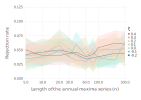

In [14]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testSS_dataSS, range_ξ, "nyear",
                        xaxis_label = "Length of the annual maxima series (n)",
                        xticks = log10.([5,10,20,30,60,100,300]),
                        yticks = 0.0:0.025:0.125, 
                        log_scale_xaxis = true)

In [15]:
draw(PDF(joinpath(figs_directory, "SS.pdf"), 16cm, 10cm), p)

## General Scaling

### Generating test results

In [16]:
# preset parameters (used in every simulation)
μ = 2
σ = 0.3
α = 0.7
δ = 3/60;

In [17]:
# The following function returns a dataframe containing simulated pvalues of the test applied on general scaling,
# when data are simulated according to general scaling.
#
# The 4 columns of the returned dataframe are : ξ , nyear , key , pval.
# "ξ" and "nyear" contain the shape parameter value and the sample size (number of observations) used for simulation.
# Those values range in range_ξ and range_nyear
# For each pair (ξ,nyear), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testGS_dataGS(range_ξ, range_nyear, Nsimul)

    big_data = DataFrame(ξ = Float64[], nyear = Int64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ

        gen_model = GeneralScaling(d_ref, μ, σ, ξ, α, δ) # model used for simulation

        for nyear in range_nyear
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, GeneralScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:nyear] .= nyear
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testGS_dataGS (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [18]:
# Random.seed!(1)
# @suppress begin
#     global results_testGS_dataGS = generate_results_testGS_dataGS(range_ξ, range_nyear, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "GS.csv"), results_testGS_dataGS)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We compare the empirical rejection rate to the nominal rate ($0.05$). We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [19]:
# retreiving stored simulation results
results_testGS_dataGS = CSV.read(joinpath(objs_directory, "GS.csv"), DataFrame);

In [20]:
# plot_data_testGS_dataGS is the dataframe that contains the data to be plotted.
# For each nyear and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testGS_dataGS = crossjoin(DataFrame(nyear = range_nyear),  DataFrame(ξ = range_ξ));

In [21]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testGS_dataGS, [:nyear, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testGS_dataGS), Ref("nyear"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

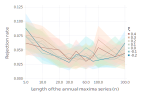

In [22]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testGS_dataGS, range_ξ, "nyear",
                        xaxis_label = "Length of the annual maxima series (n)",
                        xticks = log10.([5,10,20,30,60,100,300]),
                        yticks = 0.0:0.025:0.125, 
                        log_scale_xaxis = true)

In [23]:
draw(PDF(joinpath(figs_directory, "GS.pdf"), 16cm, 10cm), p)

# Test power

To study the test power (or type II error), data are simulated according to an alternative hypothesis (general scaling, hybrid scaling or composite scaling when the null hypothesis is simple scaling; hybrid scaling or composite scaling when the null hypothesis is general scaling) and the test (on simple scaling or general scaling) is performed at a $5$% rejection rate.

# Test power as a function of the gap with the null hypothesis

The empirical rejection rate is measured as a function of $\xi$ and of the size of the gap with the null hypothesis. The sample size (number of years of observation) is fixed, equal to $n=60$ years.

In [24]:
nyear = 60

60

## Test for simple scaling

In [25]:
# directory where to store simulation results
objs_directory = joinpath("simulation_results", "test_power", "test_SS", "dependence_over_gapwithH0");
# directory where to store figures
figs_directory = joinpath("figures", "test_power", "test_SS", "dependence_over_gapwithH0");

In [26]:
# preset parameters (used in every simulation)
μ = 2
σ = 0.3
α = 0.7;

### Alternative : general scaling 

For that alternative, the gap with the null hypothesis is defined as $\delta / d_{min}$.

In [27]:
# range of values for the simulation parameters

# range_gap = [0.05, 0.2]; # small for testing
# range_ξ = [-0.2,0.1,0.4]; # small for testing
# Nsimul = 10; # small for testing
# 
# range_gap = [[0] ; 0.05:0.05:0.1 ; [0.2,0.4,0.8,1.0]];
# range_ξ = -0.2:0.2:0.4;
# Nsimul = 50;

range_gap = [[0] ; 0.025:0.025:0.1 ; [0.15,0.2,0.3,0.4,0.6,0.8,1.0]];
range_ξ = -0.2:0.1:0.4;
Nsimul = 500;

#### Generating test results

In [28]:
# The following function returns a dataframe containing simulated pvalues of the test applied on simple scaling,
# when data are simulated according to general scaling, depending on the gap size with the null hypothesis.
#
# The 4 columns of the returned dataframe are : ξ , gap , key , pval.
# "ξ" and "gap" contain the shape parameter value and the gap size (δ / d_min) for simulation.
# Those values range in range_ξ and range_gap
# For each pair (ξ,gap), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testSS_dataGS_gap(range_ξ, range_gap, Nsimul)

    big_data = DataFrame(ξ = Float64[], gap = Float64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ

        for gap in range_gap
            
            δ = gap * minimum(durations)
            gen_model = GeneralScaling(d_ref, μ, σ, ξ, α, δ) # model used for simulation
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, SimpleScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:gap] .= gap
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testSS_dataGS_gap (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [29]:
# Random.seed!(1)
# @suppress begin
#     global results_testSS_dataGS_gap = generate_results_testSS_dataGS_gap(range_ξ, range_gap, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "GS.csv"), results_testSS_dataGS_gap)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [30]:
# retreiving stored simulation results
results_testSS_dataGS_gap = CSV.read(joinpath(objs_directory, "GS.csv"), DataFrame);

In [31]:
# plot_data_testSS_dataGS_gap is the dataframe that contains the data to be plotted.
# For each gap size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testSS_dataGS_gap = crossjoin(DataFrame(gap = range_gap),  DataFrame(ξ = range_ξ));

In [32]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testSS_dataGS_gap, [:gap, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testSS_dataGS_gap), Ref("gap"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

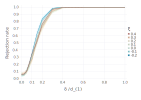

In [33]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testSS_dataGS_gap, range_ξ, "gap",
                        xaxis_label = "δ / d_(1)",
                        xticks = [0,0.1,0.2,0.4,0.6,0.8,1.0],
                        yticks = 0.0:0.1:1)

In [34]:
draw(PDF(joinpath(figs_directory, "GS.pdf"), 16cm, 10cm), p)

### Alternative : hybrid scaling 

For that alternative, the gap with the null hypothesis is defined as $(\alpha_1 - \alpha_2) / \alpha_2$. $\alpha_2$ is fixed and equal to $\alpha$ (preset parameter for the simple scaling model). The breakpoint duration is fixed equal to 1h.

In [35]:
d_break = 1;

In [36]:
# range of values for the simulation parameters

# range_gap = [-0.05, 0.1]; # small for testing
# range_ξ = [-0.2,0.1,0.4]; # small for testing
# Nsimul = 10; # small for testing
# 
# range_gap = [ reverse( - [0.05:0.05:0.1 ; [0.2,0.3]]); [0]; [0.05:0.05:0.1 ; [0.2,0.3]] ];
# range_ξ = -0.2:0.2:0.4;
# Nsimul = 50;

range_gap = [ reverse( - [0.025:0.025:0.1 ; [0.15,0.2,0.3]]); [0]; [0.025:0.025:0.1 ; [0.15,0.2,0.3]] ];
range_ξ = -0.2:0.1:0.4;
Nsimul = 500;

#### Generating test results

In [37]:
# The following function returns a dataframe containing simulated pvalues of the test applied on simple scaling,
# when data are simulated according to hybrid scaling, depending on the gap size with the null hypothesis.
#
# The 4 columns of the returned dataframe are : ξ , gap , key , pval.
# "ξ" and "gap" contain the shape parameter value and the gap size ((α₁ - α₂) / α₂) for simulation.
# Those values range in range_ξ and range_gap
# For each pair (ξ,gap), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testSS_dataHS_gap(range_ξ, range_gap, Nsimul)

    big_data = DataFrame(ξ = Float64[], gap = Float64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ

        for gap in range_gap
            
            α₂ = α
            α₁ = α₂ + α₂ * gap
            gen_model = HybridScaling(d_ref, d_break, μ, σ, ξ, α₁, α₂) # model used for simulation
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, SimpleScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:gap] .= gap
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testSS_dataHS_gap (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [38]:
# Random.seed!(1)
# @suppress begin
#     global results_testSS_dataHS_gap = generate_results_testSS_dataHS_gap(range_ξ, range_gap, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "HS.csv"), results_testSS_dataHS_gap)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [39]:
# retreiving stored simulation results
results_testSS_dataHS_gap = CSV.read(joinpath(objs_directory, "HS.csv"), DataFrame);

In [40]:
# plot_data_testSS_dataHS_gap is the dataframe that contains the data to be plotted.
# For each gap size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testSS_dataHS_gap = crossjoin(DataFrame(gap = range_gap),  DataFrame(ξ = range_ξ));

In [41]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testSS_dataHS_gap, [:gap, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testSS_dataHS_gap), Ref("gap"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

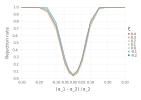

In [42]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testSS_dataHS_gap, range_ξ, "gap",
                        xaxis_label = "(α_1 - α_2) / α_2",
                        xticks = [ reverse( - [0.05,0.1,0.2,0.3]); [0]; [0.05,0.1,0.2,0.3] ],
                        yticks = 0.0:0.1:1)

In [43]:
draw(PDF(joinpath(figs_directory, "HS.pdf"), 16cm, 10cm), p)

### Alternative : composite scaling 

For that alternative, the gap with the null hypothesis is defined as $(\alpha_\sigma - \alpha_\mu) / \alpha_\mu$. $\alpha_\mu$ is fixed and equal to $\alpha$ (preset parameter for the simple scaling model).

In [44]:
# range of values for the simulation parameters

# range_gap = [-0.2, 0.3]; # small for testing
# range_ξ = [-0.2,0.1,0.4]; # small for testing
# Nsimul = 10; # small for testing
# 
# range_gap = [ reverse( - [0.1,0.3,0.6]); [0]; [0.1,0.3,0.6]];
# range_ξ = -0.2:0.2:0.4;
# Nsimul = 50;

range_gap = [ reverse( - [0.05,0.1,0.2,0.3,0.4,0.6]); [0]; [0.05,0.1,0.2,0.3,0.4,0.6]];
range_ξ = -0.2:0.1:0.4;
Nsimul = 500;

#### Generating test results

In [45]:
# The following function returns a dataframe containing simulated pvalues of the test applied on simple scaling,
# when data are simulated according to composite scaling, depending on the gap size with the null hypothesis.
#
# The 4 columns of the returned dataframe are : ξ , gap , key , pval.
# "ξ" and "gap" contain the shape parameter value and the gap size ((α_σ - α_μ) / α_μ) for simulation.
# Those values range in range_ξ and range_gap
# For each pair (ξ,gap), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testSS_dataCS_gap(range_ξ, range_gap, Nsimul)

    big_data = DataFrame(ξ = Float64[], gap = Float64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ

        for gap in range_gap
            
            α_μ = α
            α_σ = α_μ + α_μ * gap
            gen_model = CompositeScaling(d_ref, μ, σ, ξ, α_μ, α_σ) # model used for simulation
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, SimpleScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:gap] .= gap
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testSS_dataCS_gap (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [46]:
# Random.seed!(1)
# @suppress begin
#     global results_testSS_dataCS_gap = generate_results_testSS_dataCS_gap(range_ξ, range_gap, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "CS.csv"), results_testSS_dataCS_gap)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [47]:
# retreiving stored simulation results
results_testSS_dataCS_gap = CSV.read(joinpath(objs_directory, "CS.csv"), DataFrame);

In [48]:
# plot_data_testSS_dataCS_gap is the dataframe that contains the data to be plotted.
# For each gap size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testSS_dataCS_gap = crossjoin(DataFrame(gap = range_gap),  DataFrame(ξ = range_ξ));

In [49]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testSS_dataCS_gap, [:gap, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testSS_dataCS_gap), Ref("gap"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

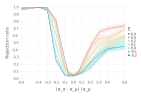

In [50]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testSS_dataCS_gap, range_ξ, "gap",
                        xaxis_label = "(α_σ - α_μ) / α_μ",
                        xticks = [ reverse(-[0.1,0.2,0.3,0.4,0.6]); [0]; [0.1,0.2,0.3,0.4,0.6] ],
                        yticks = 0.0:0.1:1)

In [51]:
draw(PDF(joinpath(figs_directory, "CS.pdf"), 16cm, 10cm), p)

## Test for general scaling

In [52]:
# directory where to store simulation results
objs_directory = joinpath("simulation_results", "test_power", "test_GS", "dependence_over_gapwithH0");
# directory where to store figures
figs_directory = joinpath("figures", "test_power", "test_GS", "dependence_over_gapwithH0");

In [53]:
# preset parameters (used in every simulation)
μ = 2
σ = 0.3
α = 0.7;

### Alternative : hybrid scaling 

For that alternative, the gap with the null hypothesis is defined as $(\alpha_1 - \alpha_2) / \alpha_2$. $\alpha_2$ is fixed and equal to $\alpha$ (preset parameter for the simple scaling model). The breakpoint duration is fixed equal to 1h.

In [54]:
d_break = 1;

In [55]:
# range of values for the simulation parameters

# range_gap = [-0.1, 0.1]; # small for testing
# range_ξ = [-0.2,0.1,0.4]; # small for testing
# Nsimul = 10; # small for testing
# 
# range_gap = [ reverse( - [0.05:0.05:0.1 ; [0.2,0.3]]); [0]; [0.05:0.05:0.1 ; [0.2,0.3]] ];
# range_ξ = -0.2:0.2:0.4;
# Nsimul = 50;

range_gap = [ reverse( - [0.025:0.025:0.1 ; [0.15,0.2,0.3]]); [0]; [0.025:0.025:0.1 ; [0.15,0.2,0.3]]];
range_ξ = -0.2:0.1:0.4;
Nsimul = 500;

#### Generating test results

In [56]:
# The following function returns a dataframe containing simulated pvalues of the test applied on general scaling,
# when data are simulated according to hybrid scaling, depending on the gap size with the null hypothesis.
#
# The 4 columns of the returned dataframe are : ξ , gap , key , pval.
# "ξ" and "gap" contain the shape parameter value and the gap size ((α₁ - α₂) / α₂) for simulation.
# Those values range in range_ξ and range_gap
# For each pair (ξ,gap), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testGS_dataHS_gap(range_ξ, range_gap, Nsimul)

    big_data = DataFrame(ξ = Float64[], gap = Float64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ

        for gap in range_gap
            
            α₂ = α
            α₁ = α₂ + α₂ * gap
            gen_model = HybridScaling(d_ref, d_break, μ, σ, ξ, α₁, α₂) # model used for simulation
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, GeneralScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:gap] .= gap
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testGS_dataHS_gap (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [57]:
# Random.seed!(1)
# @suppress begin
#     global results_testGS_dataHS_gap = generate_results_testGS_dataHS_gap(range_ξ, range_gap, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "HS.csv"), results_testGS_dataHS_gap)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [58]:
# retreiving stored simulation results
results_testGS_dataHS_gap = CSV.read(joinpath(objs_directory, "HS.csv"), DataFrame);

In [59]:
# plot_data_testGS_dataHS_gap is the dataframe that contains the data to be plotted.
# For each gap size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testGS_dataHS_gap = crossjoin(DataFrame(gap = range_gap),  DataFrame(ξ = range_ξ));

In [60]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testGS_dataHS_gap, [:gap, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testGS_dataHS_gap), Ref("gap"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

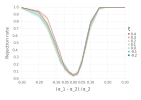

In [61]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testGS_dataHS_gap, range_ξ, "gap",
                        xaxis_label = "(α_1 - α_2) / α_2",
                        xticks = [ reverse( - [0.05,0.1,0.2,0.3]); [0]; [0.05,0.1,0.2,0.3] ],
                        yticks = 0.0:0.1:1)

In [62]:
draw(PDF(joinpath(figs_directory, "HS.pdf"), 16cm, 10cm), p)

### Alternative : composite scaling 

For that alternative, the gap with the null hypothesis is defined as $(\alpha_\sigma - \alpha_\mu) / \alpha_\mu$. $\alpha_\mu$ is fixed and equal to $\alpha$ (preset parameter for the simple scaling model).

In [63]:
# range of values for the simulation parameters

# range_gap = [-0.2, 0.3]; # small for testing
# range_ξ = [-0.2,0.1,0.4]; # small for testing
# Nsimul = 10; # small for testing
# 
# range_gap = [ reverse( - [0.1,0.3,0.6]); [0]; [0.1,0.3,0.6]];
# range_ξ = -0.2:0.2:0.4;
# Nsimul = 50;

range_gap = [ reverse( - [0.05,0.1,0.2,0.3,0.4,0.6]); [0]; [0.05,0.1,0.2,0.3,0.4,0.6]];
range_ξ = -0.2:0.1:0.4;
Nsimul = 500;

#### Generating test results

In [64]:
# The following function returns a dataframe containing simulated pvalues of the test applied on general scaling,
# when data are simulated according to composite scaling, depending on the gap size with the null hypothesis.
#
# The 4 columns of the returned dataframe are : ξ , gap , key , pval.
# "ξ" and "gap" contain the shape parameter value and the gap size ((α_σ - α_μ) / α_μ) for simulation.
# Those values range in range_ξ and range_gap
# For each pair (ξ,gap), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testGS_dataCS_gap(range_ξ, range_gap, Nsimul)

    big_data = DataFrame(ξ = Float64[], gap = Float64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ

        for gap in range_gap
            
            println(ξ, ", ", gap)
            
            α_μ = α
            α_σ = α_μ + α_μ * gap
            gen_model = CompositeScaling(d_ref, μ, σ, ξ, α_μ, α_σ) # model used for simulation
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, GeneralScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:gap] .= gap
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testGS_dataCS_gap (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [65]:
# Random.seed!(1)
# @suppress begin
#     global results_testGS_dataCS_gap = generate_results_testGS_dataCS_gap(range_ξ, range_gap, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "CS.csv"), results_testGS_dataCS_gap)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [66]:
# retreiving stored simulation results
results_testGS_dataCS_gap = CSV.read(joinpath(objs_directory, "CS.csv"), DataFrame);

In [67]:
# plot_data_testGS_dataCS_gap is the dataframe that contains the data to be plotted.
# For each gap size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testGS_dataCS_gap = crossjoin(DataFrame(gap = range_gap),  DataFrame(ξ = range_ξ));

In [68]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testGS_dataCS_gap, [:gap, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testGS_dataCS_gap), Ref("gap"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

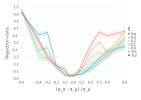

In [69]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testGS_dataCS_gap, range_ξ, "gap",
                        xaxis_label = "(α_σ - α_μ) / α_μ",
                        xticks = [ reverse(-[0.1,0.2,0.3,0.4,0.6]); [0]; [0.1,0.2,0.3,0.4,0.6] ],
                        yticks = 0.0:0.1:1)

In [70]:
draw(PDF(joinpath(figs_directory, "CS.pdf"), 16cm, 10cm), p)

# Test power as a function of the sample size

The empirical rejection rate is measured as a function of $\xi$ and of the sample size (number of years of observation). The gap with the null hypothesis will be fixed for each alternative.

In [71]:
# range of values for the simulation parameters

# range_nyear = [20,30];
# range_ξ = [-0.2,0.1,0.4]; # small for testing
# Nsimul = 10; # small for testing
# 
# range_nyear = [5,20,60,100,300];
# range_ξ = -0.2:0.2:0.4;
# Nsimul = 50;

range_nyear = [5,10,20,30,40,50,60,80,100,150,200,300];
range_ξ = -0.2:0.1:0.4;
Nsimul = 500;

## Test for simple scaling

In [72]:
# directory where to store simulation results
objs_directory = joinpath("simulation_results", "test_power", "test_SS", "dependence_over_n");
# directory where to store figures
figs_directory = joinpath("figures", "test_power", "test_SS", "dependence_over_n");

In [73]:
# preset parameters (used in every simulation)
μ = 2
σ = 0.3
α = 0.7;

### Alternative : general scaling 

For that alternative, the gap with the null hypothesis is defined as $\delta / d_{min}$.

In [74]:
gap = 0.2

0.2

#### Generating test results

In [75]:
# The following function returns a dataframe containing simulated pvalues of the test applied on simple scaling,
# when data are simulated according to general scaling, depending on the number of observations in the sample.
#
# The 4 columns of the returned dataframe are : ξ , nyear , key , pval.
# "ξ" and "nyear" contain the shape parameter value and the sample size for simulation.
# Those values range in range_ξ and range_nyear
# For each pair (ξ,nyear), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testSS_dataGS_nyear(range_ξ, range_nyear, Nsimul)

    big_data = DataFrame(ξ = Float64[], nyear = Int64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ
        
        δ = gap * minimum(durations)
        gen_model = GeneralScaling(d_ref, μ, σ, ξ, α, δ) # model used for simulation

        for nyear in range_nyear
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, SimpleScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:nyear] .= nyear
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testSS_dataGS_nyear (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [76]:
# Random.seed!(1)
# @suppress begin
#     global results_testSS_dataGS_nyear = generate_results_testSS_dataGS_nyear(range_ξ, range_nyear, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "GS.csv"), results_testSS_dataGS_nyear)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [77]:
# retreiving stored simulation results
results_testSS_dataGS_nyear = CSV.read(joinpath(objs_directory, "GS.csv"), DataFrame);

In [78]:
# plot_data_testSS_dataGS_nyear is the dataframe that contains the data to be plotted.
# For each sample size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testSS_dataGS_nyear = crossjoin(DataFrame(nyear = range_nyear),  DataFrame(ξ = range_ξ));

In [79]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testSS_dataGS_nyear, [:nyear, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testSS_dataGS_nyear), Ref("nyear"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

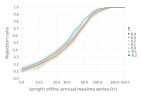

In [80]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testSS_dataGS_nyear, range_ξ, "nyear",
                        xaxis_label = "Length of the annual maxima series (n)",
                        xticks = log10.([5,10,20,30,60,100,200,300]),
                        yticks = 0.0:0.1:1, 
                        log_scale_xaxis = true)

In [81]:
draw(PDF(joinpath(figs_directory, "GS.pdf"), 16cm, 10cm), p)

### Alternative : hybrid scaling 

For that alternative, the gap with the null hypothesis is defined as $(\alpha_1 - \alpha_2) / \alpha_2$.

In [82]:
gap = -0.1

-0.1

In [83]:
d_break = 1

1

#### Generating test results

In [84]:
# The following function returns a dataframe containing simulated pvalues of the test applied on simple scaling,
# when data are simulated according to hybrid scaling, depending on the number of observations in the sample.
#
# The 4 columns of the returned dataframe are : ξ , nyear , key , pval.
# "ξ" and "nyear" contain the shape parameter value and the sample size for simulation.
# Those values range in range_ξ and range_nyear
# For each pair (ξ,nyear), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testSS_dataHS_nyear(range_ξ, range_nyear, Nsimul)

    big_data = DataFrame(ξ = Float64[], nyear = Int64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ
        
        α₂ = α
        α₁ = α₂ + α₂ * gap
        gen_model = HybridScaling(d_ref, d_break, μ, σ, ξ, α₁, α₂) # model used for simulation

        for nyear in range_nyear
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, SimpleScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:nyear] .= nyear
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testSS_dataHS_nyear (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [85]:
# Random.seed!(1)
# @suppress begin
#     global results_testSS_dataHS_nyear = generate_results_testSS_dataHS_nyear(range_ξ, range_nyear, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "HS.csv"), results_testSS_dataHS_nyear)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [86]:
# retreiving stored simulation results
results_testSS_dataHS_nyear = CSV.read(joinpath(objs_directory, "HS.csv"), DataFrame);

In [87]:
# plot_data_testSS_dataHS_nyear is the dataframe that contains the data to be plotted.
# For each sample size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testSS_dataHS_nyear = crossjoin(DataFrame(nyear = range_nyear),  DataFrame(ξ = range_ξ));

In [88]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testSS_dataHS_nyear, [:nyear, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testSS_dataHS_nyear), Ref("nyear"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

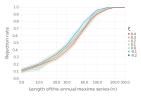

In [89]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testSS_dataHS_nyear, range_ξ, "nyear",
                        xaxis_label = "Length of the annual maxima series (n)",
                        xticks = log10.([5,10,20,30,60,100,200,300]),
                        yticks = 0.0:0.1:1, 
                        log_scale_xaxis = true)

In [90]:
draw(PDF(joinpath(figs_directory, "HS.pdf"), 16cm, 10cm), p)

### Alternative : composite scaling 

For that alternative, the gap with the null hypothesis is defined as $(\alpha_\sigma - \alpha_\mu) / \alpha_\mu$.

In [91]:
gap = 0.3

0.3

#### Generating test results

In [92]:
# The following function returns a dataframe containing simulated pvalues of the test applied on simple scaling,
# when data are simulated according to composite scaling, depending on the number of observations in the sample.
#
# The 4 columns of the returned dataframe are : ξ , nyear , key , pval.
# "ξ" and "nyear" contain the shape parameter value and the sample size for simulation.
# Those values range in range_ξ and range_nyear
# For each pair (ξ,nyear), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testSS_dataCS_nyear(range_ξ, range_nyear, Nsimul)

    big_data = DataFrame(ξ = Float64[], nyear = Int64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ
        
        α_μ = α
        α_σ = α_μ + α_μ * gap
        gen_model = CompositeScaling(d_ref, μ, σ, ξ, α_μ, α_σ) # model used for simulation
            
        for nyear in range_nyear
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, SimpleScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:nyear] .= nyear
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testSS_dataCS_nyear (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [93]:
# Random.seed!(1)
# @suppress begin
#     global results_testSS_dataCS_nyear = generate_results_testSS_dataCS_nyear(range_ξ, range_nyear, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "CS.csv"), results_testSS_dataCS_nyear)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [94]:
# retreiving stored simulation results
results_testSS_dataCS_nyear = CSV.read(joinpath(objs_directory, "CS.csv"), DataFrame);

In [95]:
# plot_data_testSS_dataCS_nyear is the dataframe that contains the data to be plotted.
# For each sample size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testSS_dataCS_nyear = crossjoin(DataFrame(nyear = range_nyear),  DataFrame(ξ = range_ξ));

In [96]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testSS_dataCS_nyear, [:nyear, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testSS_dataCS_nyear), Ref("nyear"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

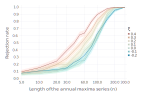

In [97]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testSS_dataCS_nyear, range_ξ, "nyear",
                        xaxis_label = "Length of the annual maxima series (n)",
                        xticks = log10.([5,10,20,30,60,100,200,300]),
                        yticks = 0.0:0.1:1, 
                        log_scale_xaxis = true)

In [98]:
draw(PDF(joinpath(figs_directory, "CS.pdf"), 16cm, 10cm), p)

## Test for general scaling

In [99]:
# directory where to store simulation results
objs_directory = joinpath("simulation_results", "test_power", "test_GS", "dependence_over_n");
# directory where to store figures
figs_directory = joinpath("figures", "test_power", "test_GS", "dependence_over_n");

In [100]:
# preset parameters (used in every simulation)
μ = 2
σ = 0.3
α = 0.7;

### Alternative : hybrid scaling 

For that alternative, the gap with the null hypothesis is defined as $(\alpha_1 - \alpha_2) / \alpha_2$.

In [101]:
gap = -0.1

-0.1

In [102]:
d_break = 1

1

#### Generating test results

In [103]:
# The following function returns a dataframe containing simulated pvalues of the test applied on general scaling,
# when data are simulated according to hybrid scaling, depending on the number of observations in the sample.
#
# The 4 columns of the returned dataframe are : ξ , nyear , key , pval.
# "ξ" and "nyear" contain the shape parameter value and the sample size for simulation.
# Those values range in range_ξ and range_nyear
# For each pair (ξ,nyear), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testGS_dataHS_nyear(range_ξ, range_nyear, Nsimul)

    big_data = DataFrame(ξ = Float64[], nyear = Int64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ
        
        α₂ = α
        α₁ = α₂ + α₂ * gap
        gen_model = HybridScaling(d_ref, d_break, μ, σ, ξ, α₁, α₂) # model used for simulation

        for nyear in range_nyear
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, GeneralScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:nyear] .= nyear
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testGS_dataHS_nyear (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [104]:
# Random.seed!(1)
# @suppress begin
#     global results_testGS_dataHS_nyear = generate_results_testGS_dataHS_nyear(range_ξ, range_nyear, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "HS.csv"), results_testGS_dataHS_nyear)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [105]:
# retreiving stored simulation results
results_testGS_dataHS_nyear = CSV.read(joinpath(objs_directory, "HS.csv"), DataFrame);

In [106]:
# plot_data_testSS_dataHS_nyear is the dataframe that contains the data to be plotted.
# For each sample size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testGS_dataHS_nyear = crossjoin(DataFrame(nyear = range_nyear),  DataFrame(ξ = range_ξ));

In [107]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testGS_dataHS_nyear, [:nyear, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testGS_dataHS_nyear), Ref("nyear"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

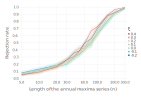

In [108]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testGS_dataHS_nyear, range_ξ, "nyear",
                        xaxis_label = "Length of the annual maxima series (n)",
                        xticks = log10.([5,10,20,30,60,100,200,300]),
                        yticks = 0.0:0.1:1, 
                        log_scale_xaxis = true)

In [109]:
draw(PDF(joinpath(figs_directory, "HS.pdf"), 16cm, 10cm), p)

### Alternative : composite scaling 

For that alternative, the gap with the null hypothesis is defined as $(\alpha_\sigma - \alpha_\mu) / \alpha_\mu$.

In [110]:
gap = 0.3

0.3

#### Generating test results

In [111]:
# The following function returns a dataframe containing simulated pvalues of the test applied on general scaling,
# when data are simulated according to composite scaling, depending on the number of observations in the sample.
#
# The 4 columns of the returned dataframe are : ξ , nyear , key , pval.
# "ξ" and "nyear" contain the shape parameter value and the sample size for simulation.
# Those values range in range_ξ and range_nyear
# For each pair (ξ,nyear), Nsimul samples are simulated. Each of these samples have a different "key" value. 
# The p-value is stored in the "pval" column.
function generate_results_testGS_dataCS_nyear(range_ξ, range_nyear, Nsimul)

    big_data = DataFrame(ξ = Float64[], nyear = Int64[], key = Int64[], pval = Float64[])
    
    for ξ in range_ξ
        
        α_μ = α
        α_σ = α_μ + α_μ * gap
        gen_model = CompositeScaling(d_ref, μ, σ, ξ, α_μ, α_σ) # model used for simulation
            
        for nyear in range_nyear
            
            # simul_test_results() is implemented in functions_simulstudy.jl
            data_simul = simul_test_results(gen_model, durations, GeneralScaling, d_out, nyear, Nsimul)
            data_simul[!,:ξ] .= ξ
            data_simul[!,:nyear] .= nyear
    
            append!(big_data, data_simul)

        end

    end

    return big_data

end

generate_results_testGS_dataCS_nyear (generic function with 1 method)

Uncomment the following cell if you want to generate new simulations.

In [112]:
# Random.seed!(1)
# @suppress begin
#     global results_testGS_dataCS_nyear = generate_results_testGS_dataCS_nyear(range_ξ, range_nyear, Nsimul)
# end
# CSV.write(joinpath(objs_directory, "CS.csv"), results_testGS_dataCS_nyear)

### Plotting

We use our test results to make a decision at a $0.05$ rate. We use a boostrap procedure in order to get confidence intervals over the empirical rejection rates.

In [113]:
# retreiving stored simulation results
results_testGS_dataCS_nyear = CSV.read(joinpath(objs_directory, "CS.csv"), DataFrame);

In [114]:
# plot_data_testSS_dataCS_nyear is the dataframe that contains the data to be plotted.
# For each sample size and ξ value, the empirical rejection result over the simulations will be calculated 
# (column "estim"), as well as its 95% boostrap confidence interval (columns "lower_bound" and "upper_bound")
plot_data_testGS_dataCS_nyear = crossjoin(DataFrame(nyear = range_nyear),  DataFrame(ξ = range_ξ));

In [115]:
# get_boostrap_interval() is implemented in functions_simulstudy.jl
transform!(plot_data_testGS_dataCS_nyear, [:nyear, :ξ] => ((x,y) -> get_boostrap_interval.(Ref(results_testGS_dataCS_nyear), Ref("nyear"), x, Ref("ξ"), y))
    => [:estim, :lower_bound, :upper_bound]);

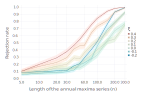

In [116]:
# plot_rejection_rates() is implemented in functions_simulstudy.jl
p = plot_rejection_rates(plot_data_testGS_dataCS_nyear, range_ξ, "nyear",
                        xaxis_label = "Length of the annual maxima series (n)",
                        xticks = log10.([5,10,20,30,60,100,200,300]),
                        yticks = 0.0:0.1:1, 
                        log_scale_xaxis = true)

In [117]:
draw(PDF(joinpath(figs_directory, "CS.pdf"), 16cm, 10cm), p)